In [67]:
from itertools import combinations
from collections import namedtuple
import numpy as np
from icecream import ic
import random

## Simple Test Problem

In [2]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
test_problem = np.load('lab2/test_problem.npy')
problem = test_problem


In [3]:
Individual = namedtuple('individual', ['genotype', 'weight'])

## Common tests

In [4]:
problem = np.load('lab2/problem_g_20.npy')

In [5]:
# Negative values?
np.any(problem < 0)

np.False_

In [6]:
# Diagonal is all zero?
np.allclose(np.diag(problem), 0.0)

True

In [7]:
# Symmetric matrix?
np.allclose(problem, problem.T)

True

In [8]:
# Triangular inequality
all(
    problem[x, y] <= problem[x, z] + problem[z, y]
    for x, y, z in list(combinations(range(problem.shape[0]), 3))
)

True

# Solution

In [9]:
POPULATION_SIZE = 50
OFFSPRING_SIZE = 20
MUTATION_RATE = 0.2

In [10]:
# Create a greedy solution starting from a random node
def greedy_solution(problem: np.ndarray, start_node: int, randomization: float = 0.2) -> list:
    solution = [start_node]
    unvisited_nodes = list(range(problem.shape[0]))
    unvisited_nodes.remove(start_node)
    while len(unvisited_nodes) > 0:
        if np.random.rand() < randomization:
            next_node = int(np.random.choice(list(unvisited_nodes)))
        else:
            last_node = solution[-1]
            min_distance = float('inf')
            next_node = None
            for node in unvisited_nodes:
                distance = problem[last_node, node]
                if distance < min_distance:
                    min_distance = distance
                    next_node = node
        
        unvisited_nodes.remove(next_node)
        solution.append(next_node)
    
    return solution


def greedy_solution_2(problem: np.ndarray, start_node: int, randomization: float = 0.2) -> list:
    # Given a node A instead of finding the closest node we check among all the nodes and we select as the next one
    # the one who has node A as the closest one. This way we reduce the chances of leaving an isolated node at the end.
    solution = [start_node]
    unvisited_nodes = list(range(problem.shape[0]))
    unvisited_nodes.remove(start_node)
    while len(unvisited_nodes) > 0:
        if np.random.rand() < randomization:
            next_node = int(np.random.choice(list(unvisited_nodes)))
        
        else:
            possible_next_nodes = []        # define all possible nodes which can be next
            for node in unvisited_nodes:    # iterate on every unvisited node
                
                closest = None
                min_distance = float('inf')
                difference = 0

                for other_node in unvisited_nodes + [solution[0]]:      # for each unvisited node find its closest node (we also consider the first node since we want to close the loop)
                    if node != other_node:
                        distance = problem[node, other_node]
                        if distance < min_distance:
                            difference = min_distance - distance        # compute how much closer this node is compared to the previous closest one
                            min_distance = distance
                            closest = other_node

                
                if closest == solution[-1]:             # if the closest node is the last node in the solution, then this node can be the next one
                    possible_next_nodes.append((node, difference))

            if len(possible_next_nodes) == 0:         # if no possible next nodes found, fallback to standard greedy
                last_node = solution[-1]
                min_distance = float('inf')
                next_node = None
                for node in unvisited_nodes:
                    distance = problem[last_node, node]
                    if distance < min_distance:
                        min_distance = distance
                        next_node = node
            else:
                # from the possible next nodes select the one which has the highest difference (i.e. which is much closer to the last node compared to the other nodes)
                possible_next_nodes.sort(key=lambda x: x[1], reverse=True)
                next_node = possible_next_nodes[0][0]
            
                

        unvisited_nodes.remove(next_node)
        solution.append(next_node)
    
    return solution


In [11]:
def compute_weight(problem: np.ndarray, solution: list) -> float:
    weight = 0.0
    for i in range(len(solution)-1):
        weight += problem[solution[i], solution[i+1]]
    weight += problem[solution[-1], solution[0]]  # Return to start
    return weight



In [12]:
def mutation(solution: Individual, problem: np.ndarray, n_mutations: int = 1) -> Individual:
    new_solution = solution.genotype.copy()
    for _ in range(n_mutations):
        # Select two different indices
        nodes = random.sample(range(len(solution)), 2)
        # Swap
        new_solution[nodes[0]], new_solution[nodes[1]] = new_solution[nodes[1]], new_solution[nodes[0]]

    # re-normalize
    idx_start = new_solution.index(0)
    new_solution = new_solution[idx_start:] + new_solution[:idx_start]

    return Individual(genotype=new_solution, weight=compute_weight(problem, new_solution))

def insert_mutation(solution: Individual, problem: np.ndarray, n_mutations: int = 1) -> Individual:
    # this mutation has the goal of minimizing the chenges in order, trying to preserve the original one
    new_solution = solution.genotype.copy()
    for _ in range(n_mutations):
        nodes = random.sample(range(len(solution.genotype)), 2)
        nodes.sort()
        new_solution = new_solution[:nodes[0] + 1] + \
            [new_solution[nodes[1]]] + \
            new_solution[nodes[0] + 1 : nodes[1]] + \
            new_solution[nodes[1] +1 : ]
        
    # re-normalize
    idx_start = new_solution.index(0)
    new_solution = new_solution[idx_start:] + new_solution[:idx_start]
        
    return Individual(genotype=new_solution, weight=compute_weight(problem, new_solution))

def inversion_mutation(solution: Individual, problem: np.ndarray, n_mutations: int = 1) -> Individual:
    new_solution = solution.genotype.copy()
    for _ in range(n_mutations):
        nodes = random.sample(range(len(solution.genotype)), 2)
        nodes.sort()
        if nodes[0] != 0:
            new_solution = new_solution[:nodes[0]] + \
                new_solution[nodes[1]:nodes[0]-1:-1] + \
                new_solution[nodes[1]+1:]
        else:
            # if nodes[0] is 0 slicing with nodes[0]-1 is an error, so we handle this case separately
            new_solution = new_solution[nodes[1]::-1] + \
                new_solution[nodes[1]+1:]
    # re-normalize
    idx_start = new_solution.index(0)
    new_solution = new_solution[idx_start:] + new_solution[:idx_start]
        
    return Individual(genotype=new_solution, weight=compute_weight(problem, new_solution))

In [13]:

def crossover(parent1: Individual, parent2: Individual, problem: np.ndarray) -> Individual:
    new_solution = []
    index1 = 1
    index2 = random.randint(1, len(parent2.genotype)-1)     # start from a random position in parent2
    turn = 1

    # both parents start with the same node (0)
    new_solution.append(parent1.genotype[0])
    not_included = list(range(1, len(parent1.genotype)))

    while True:
        # pick nodes drom parent 1, then when we encounter the node which is in parent2.genotype[index2] we start picking from parent 2
        # Then again we switch when we encounter the node which is in parent1.genotype[index1]
        if turn%2 == 1:
            if parent1.genotype[index1] in not_included:
                new_solution.append(parent1.genotype[index1])
                not_included.remove(parent1.genotype[index1])
            if parent1.genotype[index1] == parent2.genotype[index2]:
                turn += 1
            index1 = (index1 + 1) % len(parent1.genotype)
        else:
            if parent2.genotype[index2] in not_included:
                new_solution.append(parent2.genotype[index2])
                not_included.remove(parent2.genotype[index2])
            if parent2.genotype[index2] == parent1.genotype[index1]:
                turn += 1
            index2 = (index2 + 1) % len(parent2.genotype)

        if len(new_solution) == len(parent1.genotype):
            break

    return Individual(genotype=new_solution, weight=compute_weight(problem, new_solution))

def ERX_crossover(parent1: Individual, parent2: Individual, problem: np.ndarray, start: int=None) -> Individual:
    n = len(parent1.genotype)
    # build an edge table: edge -> list of close edges
    edges = [set() for _ in range(n)]

    # function to build the edge table
    def add_adj(p):
        for i, node in enumerate(p):
            edges[node].add(p[(i+1) % n])           # add the following node
            edges[node].add(p[(i-1+n) % n])         # also add the previous node

    # helper to remove a node from all the adjacences
    def remove_node_from_edges(node):
        for s in edges:
            s.discard(node)

    add_adj(parent1.genotype)
    add_adj(parent2.genotype)

    not_included = list(range(0, n))
    if start is None:
        current = random.choice(parent1.genotype)
    else:
        current = start
    new_solution = [current]

    not_included.remove(current)
    remove_node_from_edges(current)


    while not_included:
        candidates = [c for c in edges[current] if c in not_included]    # the candidates nodes are the ones connected through an edge in the parents
        if not candidates:
            # no valid city to choose from, so we pick the closest one
            next_node = min(not_included, key=lambda c: problem[current][c])
        else:
            # we choose the node with the lowest degree
            min_deg = min(len(edges[c]) for c in candidates)
            best = [c for c in candidates if len(edges[c]) == min_deg]
            if len(best) == 1:
                next_node = best[0]
            else:
                # we pick the closest node among candidates
                next_node = min(best, key=lambda c: problem[current][c])


        new_solution.append(next_node)
        not_included.remove(next_node)
        remove_node_from_edges(next_node)
        current = next_node

    idx_start = new_solution.index(0)
    new_solution = new_solution[idx_start:] + new_solution[:idx_start]

    return Individual(genotype=new_solution, weight=compute_weight(problem, new_solution))

In [14]:
def tournament_selection(population: list, tournament_size: int = 2) -> Individual:
    tournament = random.sample(population, tournament_size)
    return min(tournament, key=lambda ind: ind.weight)

In [15]:
def print_test_solution(solution: list):
    for i, city_ind in enumerate(solution):
        print(f"{CITIES[city_ind]} --{test_problem[city_ind, solution[(i+1) % len(solution)]]}--> ", end="")
        if (i+1)%4==0:
            print()
    print(f"Total distance: {compute_weight(test_problem, solution)}")

In [16]:
# Create a population of random greedy solutions
def create_population(problem: np.ndarray, randomization: float = 0.2, population_size: int = POPULATION_SIZE) -> list:
    population = []
    triangular = all(
        problem[x, y] <= problem[x, z] + problem[z, y]
        for x, y, z in list(combinations(range(problem.shape[0]), 3))
    )
    for _ in range(population_size):
        start_node = random.randint(0, problem.shape[0]-1)
        if triangular:
            # if the problem satisfies the triangular inequality it is reasonable to choose a standard greedy solution
            # in which for each node we select the closest one
            solution = greedy_solution(problem, start_node, randomization)
        else:
            # if the problem does not satisfy the triangular inequality we can use a different greedy approach
            # in which we try to avoid leaving isolated nodes at the end
            solution = greedy_solution_2(problem, start_node, randomization)

        # After creating a greedy solution starting from the node start_node I want to "normalize" it
        # so that all solutions start from node 0, even though they are composed by different sequences of nodes
        idx_start = solution.index(0)
        solution = solution[idx_start:] + solution[:idx_start]
        
        # After that we can compute the weight
        weight = compute_weight(problem, solution)
        population.append(Individual(genotype=solution, weight=weight))

    return population


In [17]:
def evolutionary_algorithm(problem: np.ndarray, 
                           generations: int = 1000,
                           initial_randomization: float = 0.2,
                           population_size: int = POPULATION_SIZE,
                           offspring_size: int = OFFSPRING_SIZE,
                           # schedule parameters
                           mrate_start: float = 0.35, mrate_end: float = 0.2,
                           nmut_start: int = 5, nmut_end: int = 1,
                           local_start: float = 0.0, local_end: float = 0.5,
                           tour_start: int = 2, tour_end: int = 4,
                           ) -> list:
    
    def lerp(a, b, t):
        return a + (b - a) * t

    population = create_population(problem, initial_randomization, population_size)
    best_solution = Individual(genotype=None, weight=float('inf'))

    symmetrical = np.allclose(problem, problem.T)

    # print(f"Initial best solution weight: {min(population, key=lambda ind: ind.weight).weight}")

    for generation in range(generations):
        t = generation / max(1, generations - 1)    # used for the progress
        offsprings = []

        # scheduled params
        cur_mrate = lerp(mrate_start, mrate_end, t)
        cur_nmut_max = max(1, int(round(lerp(nmut_start, nmut_end, t))))
        cur_local_prob = lerp(local_start, local_end, t)
        cur_tournament = max(2, int(round(lerp(tour_start, tour_end, t))))

        # generatin of the offsprings
        for _ in range(offspring_size):
            if np.random.rand() < cur_mrate:
                # Mutation
                parent = tournament_selection(population, tournament_size=cur_tournament)
                n_mut = random.randint(1, cur_nmut_max)

                if symmetrical:
                    # in case we have a symmetrical matrix we are interested in minimizing the changes in the edges
                    offspring = inversion_mutation(parent, problem, n_mutations=n_mut)
                else:
                    # in case we have an asymmetrical matrix we want to preserve as much as possible the relative order
                    offspring = insert_mutation(parent, problem, n_mutations=n_mut)

            else:
                # Crossover
                parent1 = tournament_selection(population, tournament_size=cur_tournament)
                parent2 = tournament_selection(population, tournament_size=cur_tournament)
                if symmetrical:
                    # in case we have a symmetrical matrix we are interested in minimizing the changes in the edges
                    offspring = ERX_crossover(parent1, parent2, problem)
                else:
                    # in case we have an asymmetrical matrix we want to preserve as much as possible the relative order
                    offspring = crossover(parent1, parent2, problem)
                
                # ic(parent1, parent2, offspring)

            offsprings.append(offspring)

        # Add the offsprings to the population
        # Steady state approach
        population.extend(offsprings)
        
        # Sort the population by weight
        population.sort(key=lambda ind: ind.weight)
        population = population[:population_size]

        # Keep track of the best solution
        if population[0].weight < best_solution.weight:
            best_solution = population[0]

    return best_solution


In [20]:
for x in [10, 20, 50, 100, 200, 500, 1000]:
    problem = np.load('lab2/problem_g_' + str(x) + '.npy')
    solution = evolutionary_algorithm(problem, generations=1000, initial_randomization=0.1)
    print(f"G{x}:\tBest solution weight found: {solution.weight: .2f}")

G10:	Best solution weight found:  1497.66
G20:	Best solution weight found:  1755.51
G50:	Best solution weight found:  2727.64
G100:	Best solution weight found:  4167.37
G200:	Best solution weight found:  5832.32
G500:	Best solution weight found:  9422.04
G1000:	Best solution weight found:  13659.81


In [21]:
for x in [10, 20, 50, 100, 200, 500, 1000]:
    problem = np.load('lab2/problem_r1_' + str(x) + '.npy')
    solution = evolutionary_algorithm(problem, generations=1000, initial_randomization=0.1)
    print(f"R1_{x}:\tBest solution weight found: {solution.weight: .2f}")

R1_10:	Best solution weight found:  184.27
R1_20:	Best solution weight found:  342.42
R1_50:	Best solution weight found:  578.79
R1_100:	Best solution weight found:  898.86
R1_200:	Best solution weight found:  1477.63
R1_500:	Best solution weight found:  3132.91
R1_1000:	Best solution weight found:  5850.80


In [22]:
for x in [10, 20, 50, 100, 200, 500, 1000]:
    problem = np.load('lab2/problem_r2_' + str(x) + '.npy')
    solution = evolutionary_algorithm(problem, generations=100, initial_randomization=0.1)
    print(f"R2_{x}:\tBest solution weight found: {solution.weight: .2f}")

R2_10:	Best solution weight found: -411.70
R2_20:	Best solution weight found: -783.41
R2_50:	Best solution weight found: -2133.68
R2_100:	Best solution weight found: -4509.20
R2_200:	Best solution weight found: -8998.33
R2_500:	Best solution weight found: -22611.86
R2_1000:	Best solution weight found: -45553.85


In [ ]:
import matplotlib.pyplot as plt
import requests

CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]

# coordinates (lat, lon) for the CITIES list in the notebook
COORDS = {
    "Rome": (41.9028, 12.4964),
    "Milan": (45.4642, 9.1900),
    "Naples": (40.8518, 14.2681),
    "Turin": (45.0703, 7.6869),
    "Palermo": (38.1157, 13.3615),
    "Genoa": (44.4056, 8.9463),
    "Bologna": (44.4949, 11.3426),
    "Florence": (43.7696, 11.2558),
    "Bari": (41.1256, 16.8669),
    "Catania": (37.5079, 15.0830),
    "Venice": (45.4408, 12.3155),
    "Verona": (45.4384, 10.9916),
    "Messina": (38.1938, 15.5540),
    "Padua": (45.4064, 11.8768),
    "Trieste": (45.6495, 13.7768),
    "Taranto": (40.4710, 17.2386),
    "Brescia": (45.5416, 10.2118),
    "Prato": (43.8777, 11.1022),
    "Parma": (44.8015, 10.3279),
    "Modena": (44.6471, 10.9252),
}

GEOJSON_ITALY_URL = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries/ITA.geo.json"

def plot_solution_matplotlib(solution_genotype, problem, cities=CITIES, coords=COORDS):
    n = len(solution_genotype)

    plt.figure(figsize=(8,10))

    # try to draw Italy borders under the route using the GeoJSON
    try:
        gj = requests.get(GEOJSON_ITALY_URL, timeout=5).json()
        # geojson could be either FeatureCollection or a single Feature
        geom = None
        if gj.get('type') == 'FeatureCollection':
            # take first feature (repo provides single country)
            geom = gj['features'][0]['geometry']
        elif gj.get('type') == 'Feature':
            geom = gj['geometry']
        else:
            geom = gj.get('geometry', gj)

        polygons = []
        if geom['type'] == 'Polygon':
            polygons = [geom['coordinates']]
        elif geom['type'] == 'MultiPolygon':
            polygons = geom['coordinates']

        for poly in polygons:
            for ring in poly:
                lons = [pt[0] for pt in ring]
                lats = [pt[1] for pt in ring]
                plt.plot(lons, lats, color='0.2', linewidth=1)
    except Exception:
        # if fetching/plotting borders fails, continue without it
        pass

    # route points
    latlons = [coords[cities[i]] for i in solution_genotype] + [coords[cities[solution_genotype[0]]]]
    lats = [p[0] for p in latlons]
    lons = [p[1] for p in latlons]
    plt.plot(lons, lats, '-o', color='tab:blue', zorder=3)

    # annotate cities with index and name
    for idx, city_idx in enumerate(solution_genotype):
        name = cities[city_idx]
        lat, lon = coords[name]
        plt.text(lon + 0.08, lat + 0.05, f"{name}", fontsize=9, ha='left', va='bottom',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1), zorder=4)

    # annotate segments with weights at midpoints
    for i in range(n):
        a_idx = solution_genotype[i]
        b_idx = solution_genotype[(i + 1) % n]
        a = coords[cities[a_idx]]
        b = coords[cities[b_idx]]
        mid_lon = (a[1] + b[1]) / 2
        mid_lat = (a[0] + b[0]) / 2
        w = problem[a_idx, b_idx]
        plt.text(mid_lon, mid_lat, f"{w:.2f}", fontsize=8, color='tab:blue',
                 ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1), zorder=4)

    plt.title("TSP solution (lon, lat)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def plot_solution_on_map(solution_genotype, problem, cities=CITIES, coords=COORDS):
    plot_solution_matplotlib(solution_genotype, problem, cities, coords)

Best solution weight found: 2941.81
Rome --427.5--> Palermo --165.64--> Catania --86.76--> Messina --291.45--> 
Taranto --79.15--> Bari --220.54--> Naples --534.96--> Trieste --116.14--> 
Venice --34.44--> Padua --69.19--> Verona --61.86--> Brescia --80.1--> 
Milan --125.52--> Turin --123.92--> Genoa --117.9--> Parma --50.22--> 
Modena --37.14--> Bologna --71.26--> Prato --17.21--> Florence --230.91--> 
Total distance: 2941.81


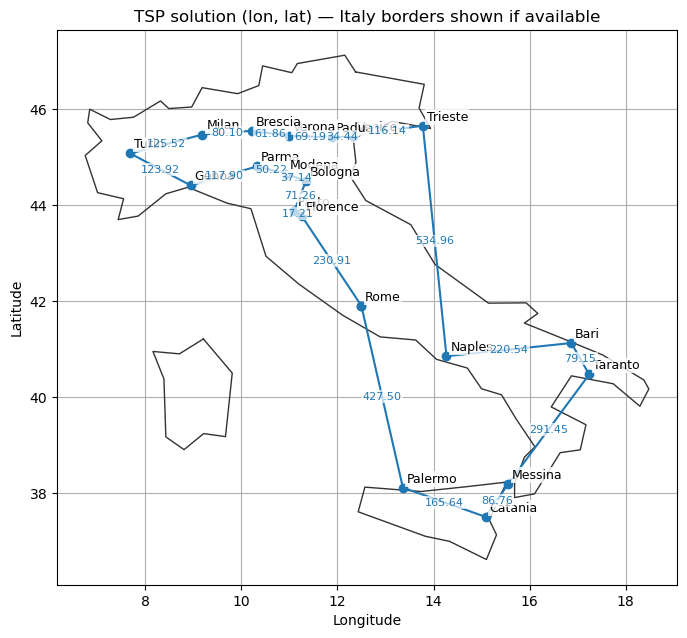

In [ ]:
solution = evolutionary_algorithm(test_problem, generations=1000, initial_randomization=0.1)
print(f"Best solution weight found: {solution.weight}")
print_test_solution(solution.genotype)

# The code for plotting the solution on the map has been written thanks to the help of Copilot
plot_solution_on_map(solution.genotype, test_problem)